In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)

In [2]:
data = pd.read_csv('house/train.csv')

data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [3]:
missing_values = data.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values[missing_values > 0])

Пропущенные значения в данных:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [4]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


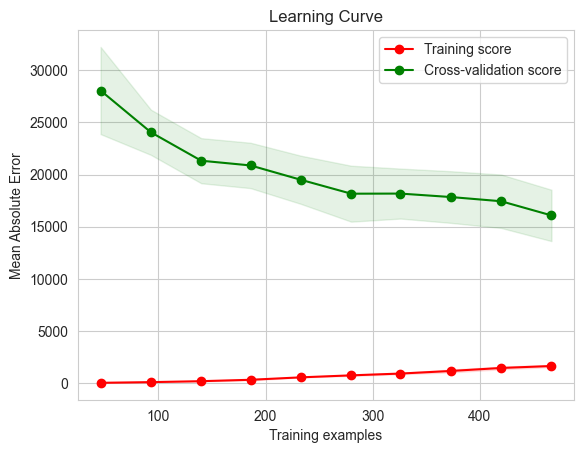

Best parameters found: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.5, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 300, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 0.6}
Best score: -16090.614462680518
MSE: 16480.422745716944
RMSE: 128.37609881016382


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.linear_model import RidgeCV
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into blending sets
X_train_blend, X_meta_blend, y_train_blend, y_meta_blend = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Define the column transformers
categorical_columns = X_train_blend.select_dtypes(include=['object']).columns
numeric_columns = X_train_blend.select_dtypes(include=['number']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Define the pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'regressor__n_estimators': [200, 300, 400],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.01, 0.03, 0.04, 0.05, 0.1],
    'regressor__subsample': [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1],
    'regressor__colsample_bytree': [0.4, 0.5, 0.6],
    'regressor__gamma': [0.2, 0.3, 0.4],
    'regressor__reg_alpha': [0.2, 0.3, 0.5, 1,],
    'regressor__reg_lambda': [0, 0.2, 0.5, 1, 1.5]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions,
    n_iter=120, 
    scoring='neg_mean_absolute_error', 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object
random_search.fit(X_train_blend, y_train_blend)

# Get the best model
best_model = random_search.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_blend, y_train_blend, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')

plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.legend(loc='best')
plt.show()


meta_features_train = best_model.predict(X_meta_blend).reshape(-1, 1)
meta_learner = RidgeCV()
meta_learner.fit(meta_features_train, y_meta_blend)

meta_features_test = best_model.predict(X_test).reshape(-1, 1)
final_predictions = meta_learner.predict(meta_features_test)

score = meta_learner.score(meta_features_test, y_test)
mse = mean_absolute_error(y_test, final_predictions)
rmse = np.sqrt(mse)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
